In [1]:
import os
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API setup complete. Now you can download datasets.")


Kaggle API setup complete. Now you can download datasets.


In [2]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 535MB/s]


In [3]:
import zipfile
import os

with zipfile.ZipFile('/content/sms-spam-collection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/spam_data')

os.listdir('/content/spam_data')

['spam.csv']

In [37]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [5]:
df = pd.read_csv('/content/spam_data/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Text Cleaning & Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
  test = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.strip()
  words = text.split()
  filtered = [word for word in words if word not in stop_words]

  return " ".join(filtered)

df['clean_message'] = df['message'].apply(clean_text)

print("\nBefore Cleaning:")
print(df['message'].iloc[0])

print("\nAfter Cleaning:")
print(df['clean_message'].iloc[0])


Before Cleaning:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

After Cleaning:
Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat


<>:5: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-904219040.py:5: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipython-input-904219040.py:7: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)


# Text Vectorization

In [14]:
vectorizer = TfidfVectorizer(max_features=3000)

X = vectorizer.fit_transform(df['clean_message'])

encode = LabelEncoder()
y = encode.fit_transform(df['label']) # ham = 0 , spam = 1

print(f"Vectorized shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Vectorized shape: (5572, 3000)
Labels shape: (5572,)


# Split Dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Models

**Naive Bayes**

In [34]:
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)

MultinomialNB()

In [28]:
y_nb_pred = nb_model.predict(X_test)

In [29]:
print(f"Accuracy: {accuracy_score(y_test, y_nb_pred)}")
print("Classification Report:\n",classification_report(y_test, y_nb_pred))

Accuracy: 0.9721973094170404
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.99      0.80      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



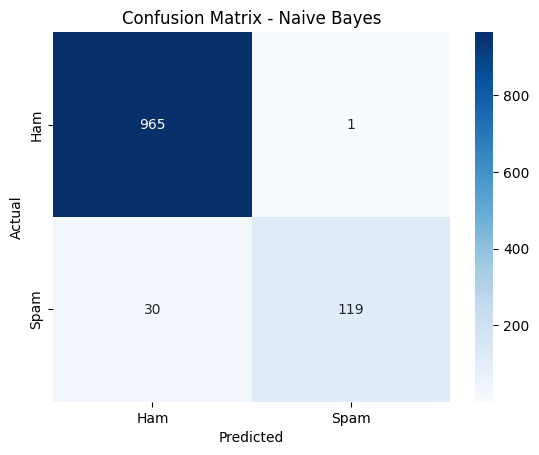

In [33]:
cm = confusion_matrix(y_test, y_nb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# Missclassified Messages

In [38]:
wrong_preds = X_test[y_nb_pred != y_test]
wrong_indices = np.where(y_nb_pred != y_test)[0]

for i in wrong_indices[:10]:
    print(f"\n Message: {df['clean_message'].iloc[X_test.indices[i]]}")
    print(f"✅ Actual: {'Spam' if y_test[i]==1 else 'Ham'}")
    print(f"❌ Predicted: {'Spam' if y_nb_pred[i]==1 else 'Ham'}")


 Message: Sorry dai thought calling lot timeslil busyi call noon
✅ Actual: Spam
❌ Predicted: Ham

 Message: Dear Subscriber ur draw å£ gift voucher b entered receipt correct ans When Elvis Presleys Birthday TXT answer
✅ Actual: Spam
❌ Predicted: Ham

 Message: Did try making another butt
✅ Actual: Spam
❌ Predicted: Ham

 Message: Sad story Man Last week bday My Wife didnt wish My Parents forgot n Kids I went work Even Colleagues wish As I entered cabin PA said Happy Bday Boss I felt special She askd lunch After lunch invited apartment We went She said u mind I go bedroom minute OK I sed sexy mood She came minuts latr wid caken My Wife My Parents My Kidz My Friends n My Colleagues All screaming SURPRISE I waiting sofa NAKED
✅ Actual: Spam
❌ Predicted: Ham

 Message: For sale arsenal dartboard Good condition doubles trebles
✅ Actual: Spam
❌ Predicted: Ham

 Message: Double mins txts Orange price linerental Motorola SonyEricsson BTooth FREENokia FREE Call MobileUpd oroptoutHVD
✅ Actual: 

In [39]:
# Save the Pipeline (Vectorizer + Model)

from sklearn.pipeline import Pipeline
import joblib

spam_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('model', MultinomialNB())
])

spam_pipeline.fit(df['clean_message'], y)

# نحفظها كملف
joblib.dump(spam_pipeline, '/content/spam_detection_pipeline.pkl')

print("✅ Pipeline saved successfully as spam_detection_pipeline.pkl")


✅ Pipeline saved successfully as spam_detection_pipeline.pkl


# Interactive CLI

In [41]:
import joblib

spam_pipeline = joblib.load('/content/spam_detection_pipeline.pkl')

print("\n Spam Detection System (Interactive Mode)")
print("Type 'exit' anytime to quit.\n")

while True:
    message = input("Enter your message: ")

    if message.lower() == "exit":
        print("\n Exiting... Have a nice day!")
        break

    prediction = spam_pipeline.predict([message])[0]

    if prediction == 1:
        print("🚫 This message is classified as: SPAM\n")
    else:
        print("✅ This message is classified as: HAM (Not Spam)\n")



 Spam Detection System (Interactive Mode)
Type 'exit' anytime to quit.

Enter your message: you won a surprise
🚫 This message is classified as: SPAM

Enter your message: let's go together
✅ This message is classified as: HAM (Not Spam)

Enter your message: exit

 Exiting... Have a nice day!
